In [1]:
notebook_dataset_path_preprocessing = r"dataset/train/"
notebook_dataset_path_cleaning = r"dataset/train/malignant/"

## Data Cleaning

*Data cleaning aims to remove erroneous data from the dataset. We remove images that don't follow a strict set of rules (e.g. have entropy <8.0 and can be decoded correctly).*
Cleaning involves below checks to be performed on images:
```
1. file jpeg signature check using magic number
2. file size thresold
3. image dimesion (must be 300x300)
        3.1 aspect ratio (must be 1)
4. Decoding validity (can the image be loaded)
5. Entropy check:
       For 24-bit RGB images, where each channel is 8-bit,
       entropy can theoretically go up to: Max Entropy = 24.0 (8 bits × 3 channels),
       where R, G & B are the 3 channels,
       generally, images with entropy 12-15 should be inspected and
       those having entropy >15 should be discarded

Checks discarded:
1. EXIF data check - no image had exif data & it wasn't required for this use case
2. Uniform color check - gave faulty results for almost all images
3. Progressive Loading Test (JPEG) - not needed for this case
4. Extension mismatch - the images had '.jpg' extension & all the files already had     'jpeg' signatures
```


In [2]:
import os
import sys
import imghdr
from PIL import Image, ImageFile
import numpy as np
import math
import json

# This completely hides all GPUs from TensorFlow.
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Increase parser tolerance for truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

/tmp/ipykernel_3457/2078295218.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
def check_magic_number(path) -> int:
    # Returns 1 if image signature is 'jpeg' (the format of the images in the database) otherwise 0

    sig_map = {
        'jpeg': [b'\xFF\xD8\xFF']
    }
    try:
        with open(path, 'rb') as f:
            header = f.read(8)
    except Exception as e:
        # print(f"Magic: ERR ({e})")
        return 0
    fmt = imghdr.what(path)
    if not fmt:
        # print("Magic: Unknown format")
        return 0
    elif any(header.startswith(s) for s in sig_map.get(fmt, [])):
        # print(f"Magic: OK ({fmt})")
        return 1
    else:
        # print(f"Magic: Mismatch ({fmt})")
        return 0


def check_file_size(path, min_size=1000, max_size=100_000_000) -> int:
    # Returns 1 if image has a valid size otherwise 0

    size = os.path.getsize(path)
    if size < min_size:
        # print(f"Size: Too small ({size} B)")
        return 0
    elif size > max_size:
        # print(f"Size: Too large ({size} B)")
        return 0
    else:
        # print(f"Size: OK ({size} B)")
        return 1


def load_image(path) -> list:
    # Returns a list of length 2, if the image can be verified and loaded correctly
    # the returned list is [PIL.Image.Image object, 1]
    # in all other cases we return [None,0].
    # The returned PIL.Image.Image object is used by check_dim() & check_entropy().
    try:
        img = Image.open(path)
        img.verify()         # structural check
        img = Image.open(path)
        img.load()           # pixel data check
        # print("Decode: OK")
        return [img, 1]
    except Exception as e:
        # print(f"Decode: ERR ({e})")
        return [None, 0]


def check_dim(img) -> int:
    # Returns 1 if dimension is 300x300, since the image of the dataset follow the same format
    # else:
    #   if width and height arent equal return 0
    #   else return -1
    w, h = img.size
    if w == 300 and h == 300:
        return 1
    else:
        if w/h == 1:
            return 0
        else:
            return -1



def check_entropy(img) -> int:
    # Regarding entropy of image 7.0 – 12.0 is the acceptable entropy
    # for colored 24-bit RGB otherwise its likely noisy or corrupted.
    # Thus, for valid images it returns 1 otherwise 0.

    # Entropy
    hist = img.histogram()
    total = sum(hist)
    probs = [h/total for h in hist if h > 0]
    entropy = -sum(p * math.log2(p) for p in probs)

    # 7.0 – 12.0 is the acceptable entropy for colored 24-bit RGB (the dataset images are 24bit RGB)
    if entropy < 5.5 or entropy > 15.0:
        return 0
    return 1

def image_checker(path) -> list:
    # Returns a list which has the following structure:
    #           [valid_magic_number, valid_file_size, valid_image_structure_and_pixel_data, valid_dimensions, valid_entropy]
    #
    # An image is VALID if this function returns the below list:
    #           [1, 1, 1, 1, 1]
    # Otherwise the image is NOT VALID, we separate those image and deal with them in main()

    valid_list=list()
    valid_list.append(check_magic_number(path))

    valid_list.append(check_file_size(path))

    img_load_result = load_image(path)

    valid_list.append(img_load_result[1])
    if img_load_result[0]:
        valid_list.append(check_dim(img_load_result[0]))
        valid_list.append(check_entropy(img_load_result[0]))
    else:
        # If the image can't even be loaded and verified by PIL then
        # checking for dimensions and entropy is useless
        # by placing -2 for (valid_dimensions, valid_entropy)
        # it is implied that the image can't be verified and loaded by PIL.
        #
        # So if an image has a valid magic number and file size but can't be loaded and verified by PIL
        # will return the below list:
        #       [1, 1, 0, -2, -2]
        valid_list.append(-2)
        valid_list.append(-2)
    return valid_list

def save_faulty_image_result(faulty_image_file, image_result):
    # faulty_image_file="test_benign.json"

    # Load existing JSON list or create a new one
    data=None
    if not os.path.exists(faulty_image_file):
        # Create the file with an empty list
        with open(faulty_image_file, 'w') as f:
            json.dump([], f)

    with open(faulty_image_file, 'r+') as f:
        data = json.load(f)
        data.append(image_result)
        f.seek(0)
        json.dump(data, f, indent=4)
        f.truncate()

In [4]:
def main():

    path = notebook_dataset_path_cleaning

    faulty_img_file="train_benign.json"
    print(f"PATH: {path}")
    ask=""
    print("Print verdict of each image?[y/n]: ",end='')
    ask=input()

    erroneous_img=0

    for i in range(5000, 9605):
        img_name = "melanoma_"+str(i)+".jpg"
        img_path = path+img_name

        image_verdict = image_checker(img_path)

        if image_verdict != [1, 1, 1, 1, 1]:
            erroneous_img+=1
            data_to_append = {
                "name": img_name,
                "image_result": image_verdict
            }
            save_faulty_image_result(faulty_img_file, data_to_append)
        if ask=="y" or ask=="Y":
            print("Image : ",img_name,"| Vertict: ",image_verdict)
    print("Erroneous images: ", erroneous_img)
    print("Done.")

main()

PATH: dataset/train/malignant/
Print verdict of each image?[y/n]: Erroneous images:  0
Done.


## Data Preprocessing
*To transform the data into a clean, consistent, and standardized format suitable for model training.
Enhances data quality, reduce noise, and ensure uniformity across the dataset, thereby improving model performance and training efficiency.*
Below are the 4 methods used for data preprocessing
```
1. image resizing (spatial normalization) (optional: all images are 300x300)
2. min-max normalization (pixel scaling) to [0, 1]
3. data augmentation
4. zero-centered normalization (standardization)
```
> Library used - Tensorflow

In [5]:
import tensorflow as tf

# forces tf to run only on cpu
#try:
#    tf.config.set_visible_devices([], 'GPU')
#except:
#    pass  # Device already initialized

2025-05-15 13:33:57.483520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747296237.577034    3457 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747296237.606629    3457 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747296237.813075    3457 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747296237.813105    3457 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747296237.813108    3457 computation_placer.cc:177] computation placer alr

In [6]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [7]:
# 1. Resize
def resize_image(image, label, target_size=(300, 300)):
    print("--- Resizing image...")
    image = tf.image.resize(image, target_size)
    return image, label
# 2. Normalize to [0, 1]
def normalize_image(image, label):
    print("--- Normalizing image to [0, 1]...")
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
# 3. Data Augmentation
def augment_image(image, label):
    print("--- Applying data augmentation...")
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label
# 4. Standardization
def standardize_image(image, label):
    print("--- Standardizing image (zero mean, unit variance)...")
    image = tf.image.per_image_standardization(image)
    return image, label

In [8]:
def build_tf_dataset(dataset_directory, batch_size=32):
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=dataset_directory,
        labels='inferred',               # Infers labels from subfolder names
        label_mode='int',                # Labels are marked as integer indices
        batch_size=batch_size,           # Return individual (img, label) pairs for custom pipeline
        image_size=(300, 300),           # Optional: initially resizes (we’ll override this later)
        shuffle=True
    )

    training_dataset = training_dataset.map(resize_image)
    training_dataset = training_dataset.map(normalize_image)
    training_dataset = training_dataset.map(augment_image)
    training_dataset = training_dataset.map(standardize_image)
    return training_dataset

In [9]:
print("\n\n\n! PREPROCESSING STARTED")
# with tf.device('/CPU:0'):
#     preprocessed_dataset = build_tf_dataset(notebook_dataset_path_preprocessing)
preprocessed_dataset = build_tf_dataset(notebook_dataset_path_preprocessing)
print("! PREPROCESSING DONE")
print("\n--- TYPE: ",type(preprocessed_dataset),"\n")




! PREPROCESSING STARTED
Found 9605 files belonging to 2 classes.


I0000 00:00:1747296252.301953    3457 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2788 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


--- Resizing image...
--- Normalizing image to [0, 1]...
--- Applying data augmentation...
--- Standardizing image (zero mean, unit variance)...
! PREPROCESSING DONE

--- TYPE:  <class 'tensorflow.python.data.ops.map_op._MapDataset'> 



## 1 - Applying ResNet50
## Feature Extraction

In [10]:
def extract_resnet50(preprocessed_dataset):
    
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input
    


    """
    Extracts ResNet50 features + labels from a (possibly‐batched) tf.data.Dataset.
    
    Args:
      preprocessed_dataset: a tf.data.Dataset yielding (images, labels).
        images may be shape [H, W, 3] *or* [B, H, W, 3].
      batch_size: if you know your dataset’s batch size, pass it here so we
        can set static shapes on the output. Otherwise leave as None, and
        we’ll set a partially‐known shape [None,224,224,3].
    
    Saves:
      - features → 'features_resnet50.npy'  
      - labels   → 'labels_resnet50.npy'
    """
    # 1) Load ResNet50 (no top, global avg pool)
    print("\t| ResNet50 |\n Starting feature extraction...")
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    
    # 2) Prepare a Python list to accumulate labels in order
    label_list = []

    # 3) A small Python function that (a) resizes & preprocesses an *entire batch*
    #    and (b) extends our label_list with that batch’s labels.
    def prepare_batch(images, labels):
        # images: either [H,W,3] or [B,H,W,3]; we treat both as a batch.
        imgs = tf.cast(images, tf.float32)
        imgs = tf.image.resize(imgs, (224, 224))
        imgs = preprocess_input(imgs * 255.0)
        
        # pull labels out into our Python list
        label_list.extend(labels.numpy().tolist())
        return imgs

    # 4) Wrap it in a tf.py_function so it’ll run *once per element of the dataset*.
    def wrapper(images, labels):
        processed = tf.py_function(
            func=prepare_batch,
            inp=[images, labels],
            Tout=tf.float32
        )
        # Now tell TF the shape of what came out:
        #  - batch dimension is either known (batch_size) or left as None
        processed.set_shape([None, 224, 224, 3])
        return processed

    # 5) Build the pipeline: map → prefetch
    print("\nPreparing images for the model...\n")
    image_ds = preprocessed_dataset.map(wrapper,
                                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    image_ds = image_ds.prefetch(tf.data.experimental.AUTOTUNE)

    # 6) Run the model
    print("\nFeature vector extraction started...\n")
    features = model.predict(image_ds, verbose=1)

    # 7) Save everything
    np.save('features_resnet50.npy', features)
    labels_array = np.array(label_list)
    np.save('labels_resnet50.npy', labels_array)

    print("\t| DONE, features and labels saved |\n")

extract_resnet50(preprocessed_dataset)

	| ResNet50 |
 Starting feature extraction...

Preparing images for the model...


Feature vector extraction started...



I0000 00:00:1747296265.753274    4528 service.cc:152] XLA service 0x72ba80048090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747296265.753312    4528 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-15 13:34:25.880502: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747296266.523280    4528 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-15 13:34:27.758427: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0} %bitcast.4447, f32[64,64,3,3]{3,2,1,0} %bitcast.4454, f32[64]{0} %bitcast.4456), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target=

  1/301 ━━━━━━━━━━━━━━━━━━━━ 55:05 11s/step

I0000 00:00:1747296272.152521    4528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step

2025-05-15 13:36:18.166564: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[5,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,64,56,56]{3,2,1,0} %bitcast.4447, f32[64,64,3,3]{3,2,1,0} %bitcast.4454, f32[64]{0} %bitcast.4456), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="resnet50_1/conv2_block1_2_conv_1/convolution" source_file="/home/rnay/pyth_envrionments/tensorflow_env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-15 13:36:19.219520: I external/local_xla/xla/service/gpu/autotuning/conv_algor

301/301 ━━━━━━━━━━━━━━━━━━━━ 122s 370ms/step
	| DONE, features and labels saved |



In [11]:
def extract_resnet50_test(
    test_dir,
    batch_size=32,
    original_size=(300, 300),
    target_size=(224, 224)
):
    import numpy as np
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input
    from tensorflow.keras.preprocessing import image_dataset_from_directory

    """
    Extracts ResNet50 features + labels from a test directory structured as:
        test_dir/
            benign/
            malignant/
    - Loads images at `original_size` (e.g. 300×300)
    - Resizes to `target_size` (224×224) before feeding into ResNet50
    - Saves:
        • features → 'features_resnet50_test.npy'  (shape: [N_test, 2048])
        • labels   → 'labels_resnet50_test.npy'    (shape: [N_test,])
    """
    # 1) Load test dataset at its original resolution (300×300)
    print("\t| Loading test dataset at 300×300… |")
    test_ds = image_dataset_from_directory(
        directory    = test_dir,
        labels       = 'inferred',
        label_mode   = 'int',
        class_names  = ['benign', 'malignant'],
        batch_size   = batch_size,
        image_size   = original_size,   # load at 300×300
        shuffle      = False
    )

    # 2) Extract all labels eagerly (pure Python), save them
    print("\t| Collecting labels… |")
    label_list = []
    for _, lbl_batch in test_ds:
        label_list.extend(lbl_batch.numpy())
    labels = np.array(label_list)
    np.save('labels_resnet50_test.npy', labels)

    # 3) Build an image-only pipeline that resizes to 224×224 + preprocesses
    def preprocess_image(img, lbl):
        # img: float32 or uint8, shape = original_size + (3,)
        img = tf.cast(img, tf.float32)
        # explicit resize to target_size
        img = tf.image.resize(img, target_size)
        # apply ResNet50/ImageNet preprocessing (zero-centering, scaling)
        return preprocess_input(img)

    print("\t| Building image-only pipeline (resize→preprocess)… |")
    image_only_ds = (
        test_ds
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )

    # 4) Load ResNet50 (no top, global avg pool) and extract features
    print("\t| Loading ResNet50 & extracting features… |")
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    features = model.predict(image_only_ds, verbose=1)

    # 5) Save feature vectors
    print("\t| Saving features to 'features_resnet50_test.npy' |")
    np.save('features_resnet50_test.npy', features)

    print("\n\t| DONE: test features + labels saved |")


#usage:
extract_resnet50_test('dataset/test')

	| Loading test dataset at 300×300… |
Found 1000 files belonging to 2 classes.
	| Collecting labels… |


2025-05-15 13:36:51.597674: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


	| Building image-only pipeline (resize→preprocess)… |
	| Loading ResNet50 & extracting features… |


2025-05-15 13:36:53.779118: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267584 bytes after encountering the first element of size 19267584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step

2025-05-15 13:37:19.490257: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0} %bitcast.4447, f32[64,64,3,3]{3,2,1,0} %bitcast.4454, f32[64]{0} %bitcast.4456), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="resnet50_1/conv2_block1_2_conv_1/convolution" source_file="/home/rnay/pyth_envrionments/tensorflow_env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-15 13:37:20.798837: I external/local_xla/xla/service/gpu/autotuning/conv_algor

32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 862ms/step
	| Saving features to 'features_resnet50_test.npy' |

	| DONE: test features + labels saved |


## ResNet50 Predictions

	| Loading precomputed features and labels |
	| Defining base classifiers |
	| Building VotingClassifier (soft voting) |
	| Training ensemble classifier |


/home/rnay/pyth_envrionments/tensorflow_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:42:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


	| Predicting on test set |

	| Test Accuracy: 0.5600 |


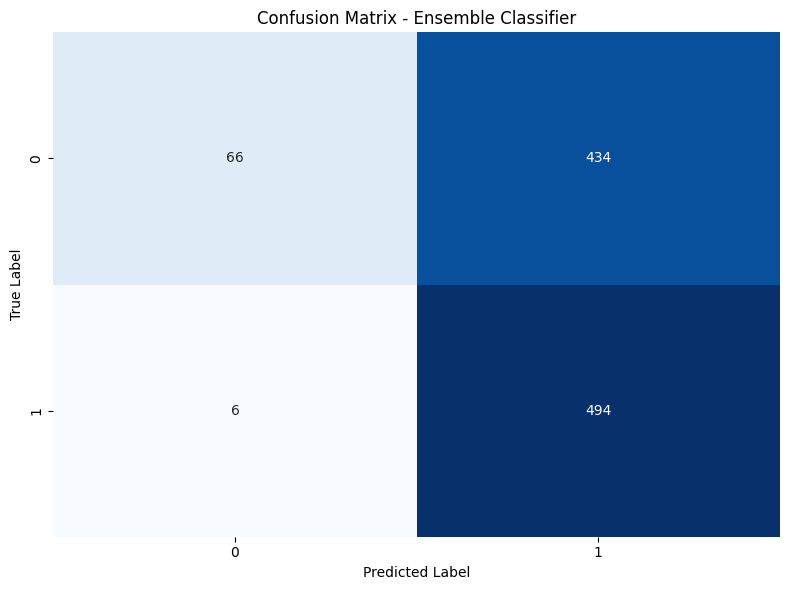

/home/rnay/pyth_envrionments/tensorflow_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:47:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_3457/1987963850.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


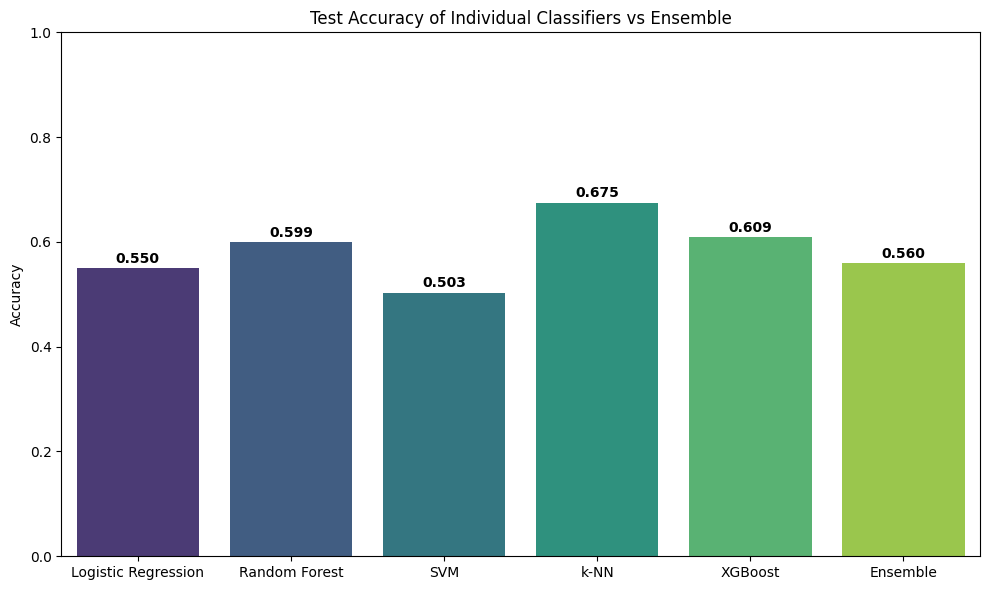

In [12]:
def train_and_evaluate_ensemble(
    train_features_path='features_resnet50.npy',
    train_labels_path='labels_resnet50.npy',
    test_features_path='features_resnet50_test.npy',
    test_labels_path='labels_resnet50_test.npy'
):
    
    import numpy as np
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import accuracy_score, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    """
    Loads precomputed ResNet50 features and labels for train and test sets,
    constructs an ensemble of various classifiers (with scaling where appropriate),
    trains the ensemble on the train data, predicts on test data, and prints accuracy.
    """
    # --------------------------------------------
    # 1. Load train and test features & labels
    # --------------------------------------------
    print("\t| Loading precomputed features and labels |")
    X_train = np.load(train_features_path)
    y_train = np.load(train_labels_path)
    X_test  = np.load(test_features_path)
    y_test  = np.load(test_labels_path)
    
    # --------------------------------------------
    # 2. Define individual classifiers (with scaling)
    # --------------------------------------------
    print("\t| Defining base classifiers |")
    # Logistic Regression (needs scaling)
    clf1 = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000))
    ])
    
    # Random Forest (tree-based, no scaler needed)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # SVM with probability estimates (needs scaling)
    clf3 = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, kernel='rbf'))
    ])
    
    # k-Nearest Neighbors (needs scaling)
    clf4 = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    
    # XGBoost (tree-based)
    clf5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # --------------------------------------------
    # 3. Build soft-voting ensemble
    # --------------------------------------------
    print("\t| Building VotingClassifier (soft voting) |")
    ensemble_clf = VotingClassifier(
        estimators=[
            ('lr', clf1),
            ('rf', clf2),
            ('svm', clf3),
            ('knn', clf4),
            ('xgb', clf5)
        ],
        voting='soft'
    )
    
    # --------------------------------------------
    # 4. Train ensemble on train data
    # --------------------------------------------
    print("\t| Training ensemble classifier |")
    ensemble_clf.fit(X_train, y_train)
    
    # --------------------------------------------
    # 5. Predict on test data and evaluate
    # --------------------------------------------
    print("\t| Predicting on test set |")
    y_pred = ensemble_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n\t| Test Accuracy: {acc:.4f} |")

    # --------------------------------------------
    # 6. Additional visualization of results
    # --------------------------------------------

    # Confusion Matrix Heatmap for the ensemble predictions
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix - Ensemble Classifier")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Evaluate individual classifiers on test set for comparison
    classifiers = {
        'Logistic Regression': clf1,
        'Random Forest': clf2,
        'SVM': clf3,
        'k-NN': clf4,
        'XGBoost': clf5
    }

    individual_accuracies = []
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)  # train individual classifier
        y_pred_ind = clf.predict(X_test)
        acc_ind = accuracy_score(y_test, y_pred_ind)
        individual_accuracies.append(acc_ind)

    # Bar plot comparing individual classifier accuracies and ensemble accuracy
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=list(classifiers.keys()) + ['Ensemble'],
        y=individual_accuracies + [acc],
        palette='viridis'
    )
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy of Individual Classifiers vs Ensemble')
    for i, v in enumerate(individual_accuracies + [acc]):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    return ensemble_clf, acc


# Example usage:
ensemble_model, test_acc = train_and_evaluate_ensemble(
    train_features_path='features_resnet50.npy',
    train_labels_path='labels_resnet50.npy',
    test_features_path='features_resnet50_test.npy',
    test_labels_path='labels_resnet50_test.npy'
)

## 2 - Applying MobileNetV2
## Feature Extraction

In [ ]:
def extract_and_save_features(dataset_path):

    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    print("🔄 Starting feature extraction...")
    dataset = build_tf_dataset(dataset_path)
    model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(300, 300, 3))

    features, labels = [], []
    for images, lbls in dataset:
        images = preprocess_input(images)
        feat = model(images, training=False)
        features.append(feat.numpy())
        labels.append(lbls.numpy())

    X = np.concatenate(features, axis=0)
    y = np.concatenate(labels, axis=0)

    np.save('features_mobilenetv2.npy', X)
    np.save('labels_mobilenetv2.npy', y)
    print(f"✅ Features and labels saved to `{output_dir}/`.")


extract_and_save_features(notebook_dataset_path_preprocessing)

## MobileNetV2 Preditctions

In [14]:
def train_from_saved_features():
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.decomposition import PCA
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

    # Load features extracted using MobileNetV2
    X = np.load('features_mobilenetv2.npy')
    y = np.load('labels_mobilenetv2.npy')

    print(f"📦 LOADED DATASET FEATURES: {X.shape}, labels: {y.shape}")

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define ensemble model using soft voting
    ensemble = VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('gb', GradientBoostingClassifier(n_estimators=100))
    ], voting='soft')

    print("🧠 Training ensemble...")
    ensemble.fit(X_train, y_train)

    # Predict on test set
    y_pred = ensemble.predict(X_test)

    # Accuracy metric
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ ENSEMBLE ACCURACY: {acc:.4f}")

    # --------------------- 🔍 ADVANCED VISUALIZATIONS --------------------- #

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # 2. Classification Report as Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
    plt.title("Classification Report")
    plt.tight_layout()
    plt.show()

    # 3. ROC Curve (Binary classification only)
    if len(np.unique(y)) == 2:
        y_proba = ensemble.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='darkorange')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    # 4. PCA Projection (2D) for visualizing feature space
    pca = PCA(n_components=2)
    X_proj = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap='viridis', s=15, alpha=0.7)
    plt.title("2D PCA Projection of MobileNetV2 Features")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, label='Class Label')
    plt.tight_layout()
    plt.show()


📦 LOADED DATASET FEATURES: (9605, 1280), labels: (9605,)
🧠 Training ensemble...

✅ ENSEMBLE ACCURACY: 0.9089


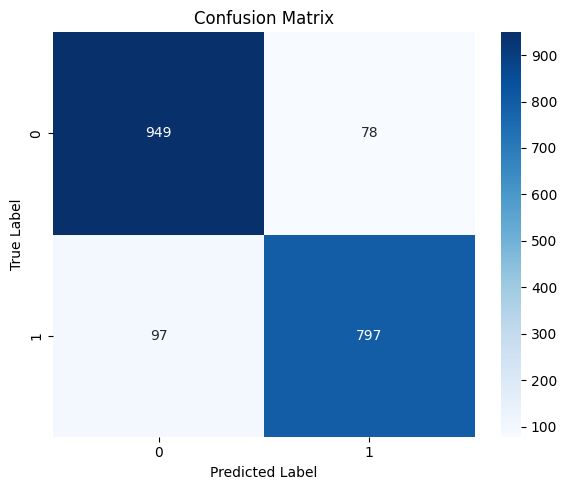

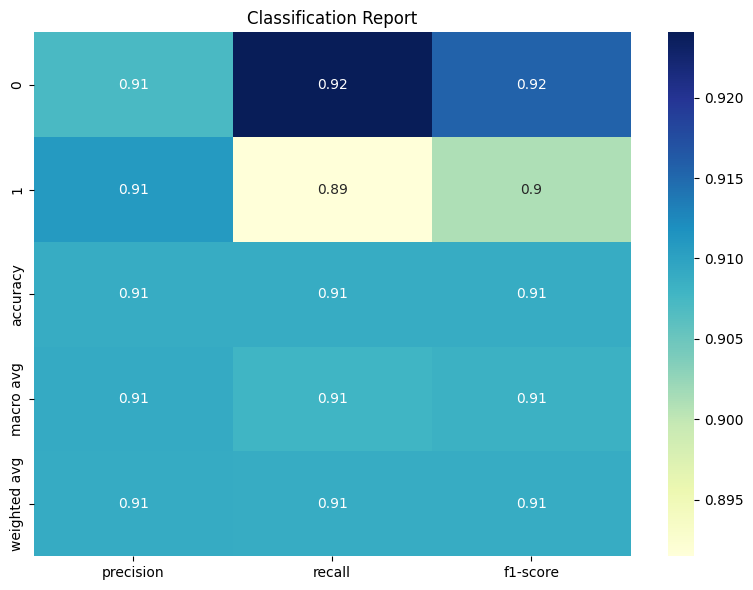

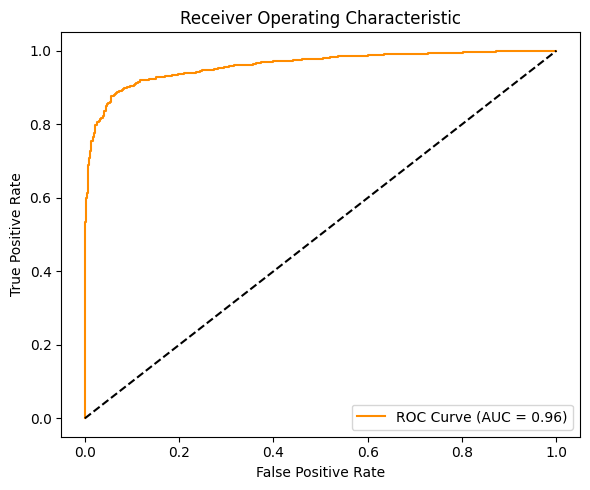

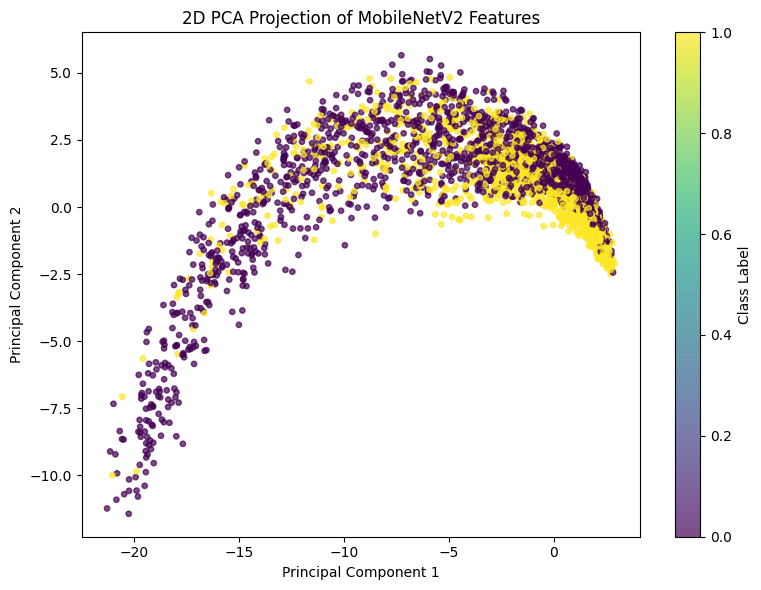

In [15]:
train_from_saved_features()

## 3 - Applying ViT (pyTorch)
## Feature Extraction

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel

2025-05-14 01:32:42.473745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747166562.491702   34636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747166562.496786   34636 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747166562.511736   34636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747166562.511791   34636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747166562.511792   34636 computation_placer.cc:177] computation placer alr

In [ ]:
# Load the pre-trained Vision Transformer image processor and model
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model.eval()  # Set the model to evaluation mode


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
def extract_vit_features(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = image_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Extract the [CLS] token
    return cls_embedding.squeeze().numpy()

In [ ]:
def load_dataset_and_extract_features(root_folder):
    features = []
    labels = []

    for label in os.listdir(root_folder):
        class_dir = os.path.join(root_folder, label)
        if not os.path.isdir(class_dir):
            continue

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            try:
                feat = extract_vit_features(img_path)
                features.append(feat)
                labels.append(label)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

    return np.array(features), np.array(labels)


In [ ]:
train_features, train_labels = load_dataset_and_extract_features('dataset/train')
test_features, test_labels = load_dataset_and_extract_features('dataset/test')


In [ ]:
print(train_features[0].shape)
print(train_labels[0])
print(train_labels[5000])

(768,)
malignant
benign


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)

In [ ]:
print(train_labels_encoded[0])
print(train_labels_encoded[5000])

1
0


In [ ]:
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels_encoded)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels_encoded)

## ViT Predictions

/home/rnay/my_py_env/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/rnay/my_py_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:06:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Ensemble Accuracy: 0.914

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       500
           1       0.94      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



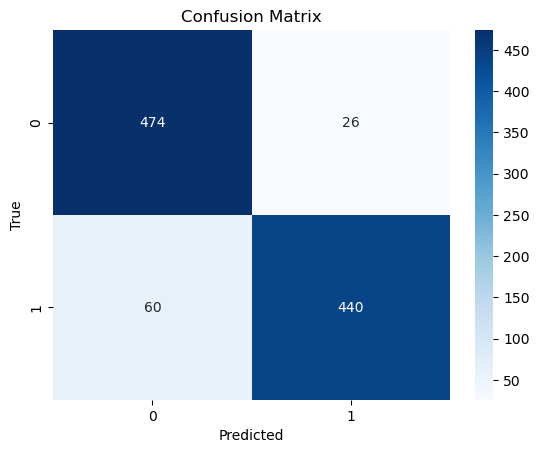

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create classifiers (with scaling where needed)
clf1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=42))
clf4 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
clf5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# VotingClassifier (soft voting uses predicted probabilities)
ensemble_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('rf', clf2),
        ('svm', clf3),
        ('knn', clf4),
        ('xgb', clf5)
    ],
    voting='soft'
)

# Train
ensemble_clf.fit(train_features, train_labels_encoded)

# Predict
y_pred = ensemble_clf.predict(test_features)

# Evaluation
print("\n✅ Ensemble Accuracy:", accuracy_score(test_labels_encoded, y_pred))
print("\n📊 Classification Report:\n", classification_report(test_labels_encoded, y_pred))

# Optional: Confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels_encoded), yticklabels=np.unique(test_labels_encoded))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
